# Previsão de Chuva - Classificação (Abordagem 1)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import data_prep

## Processamento de Dados
Função que faz todo o tratamento dos arquivos de entrada e gera dois Dataframes, um com os dados de entrada, e outro com os dados de saída.\
Código completo no arquivo `data_prep.py`

In [2]:
df_in, df_out = data_prep.prep_data()

## Abordagem 1: Separação em Quadrimestres
Reorganizamos os dataframes em Quadrimestres em vez de Meses, agregando os dados.\
Nessa abordagem, usamos a média (`mean`) dos atributos de entrada, e a soma (`sum`) da precipitação total.

In [3]:
# Criar cópias dos dataframes originais para evitar modificações diretas
df_in_copy = df_in.copy()
df_out_copy = df_out.copy()

# Função para identificar o quadrimestre
def assign_quad(month):
    if month in [1, 2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11, 12]:
        return 3

# Adicionar a coluna de quadrimestre
df_in_copy['QUAD'] = df_in_copy['MON'].apply(assign_quad)
df_out_copy['QUAD'] = df_out_copy['MON'].apply(assign_quad)

# Filtrar os dados de entrada e saída para incluir apenas anos de 1982 a 2023
df_in_copy = df_in_copy[(df_in_copy['YEAR'] >= 1982) & (df_in_copy['YEAR'] <= 2023)]
df_out_copy = df_out_copy[(df_out_copy['YEAR'] >= 1982) & (df_out_copy['YEAR'] <= 2023)]

# Agregar dados de entrada por quadrimestre
aggregated_in = df_in_copy.groupby(['YEAR', 'QUAD']).agg({
    '1_TW_CP': 'mean',
    '2_DarwinPr': 'mean',
    '3_TW_EP': 'mean',
    '4_TahitiPr': 'mean',
    '5_TW_WP': 'mean',
    '6_NATL': 'mean',
    '6_SATL': 'mean',
    '6_TROP': 'mean',
    '7_NINO1+2': 'mean',
    '7_NINO3': 'mean',
    '7_NINO4': 'mean',
    '7_NINO3.4': 'mean'
}).reset_index()

# Agregar precipitação por quadrimestre (total acumulada)
aggregated_out = df_out_copy.groupby(['YEAR', 'QUAD']).agg({
    'PRECIP': 'sum'  # Soma da precipitação para o quadrimestre
}).reset_index()

# Mesclar os dados de entrada e saída agregados
aggregated_data = pd.merge(aggregated_in, aggregated_out, on=['YEAR', 'QUAD'])

# Exibir o dataframe resultante
#aggregated_data

# Classificação

## Definição das Classes
Começando por uma classificação binária, vamos dividir os resultados entre `Baixa Precipitação` e `Alta Precipitação`, com base na mediana dos valores no dataframe.

In [4]:
# Calcular a mediana da precipitação
median_precip = aggregated_data['PRECIP'].median()

# Criar uma função para classificar a precipitação
def classify_precipitation(precip):
    if precip <= median_precip:
        return 'Baixa Precipitação'
    else:
        return 'Alta Precipitação'

# Aplicar a função para criar a nova coluna de classe
aggregated_data['Precip_Class'] = aggregated_data['PRECIP'].apply(classify_precipitation)

# Exibir o dataframe resultante
#aggregated_data

## PCA

### Separação em Treino e Teste
Antes de realizar o PCA de fato, fazemos a divisão do dataframe em treino e teste com o `train_test_split`.\
Isso é importante para que o PCA não inclua alguma informação do conjunto de teste, sendo aplicado somente nos dados de treinamento.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Separar as variáveis de entrada e a variável alvo
features = aggregated_data.drop(columns=['YEAR', 'QUAD', 'PRECIP', 'Precip_Class'])
target = aggregated_data['Precip_Class']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Elbow Method
Utilizando um gráfico de cotovelo, verificamos o número de componentes que vamos utilizar para atingir a variância explicada desejada.

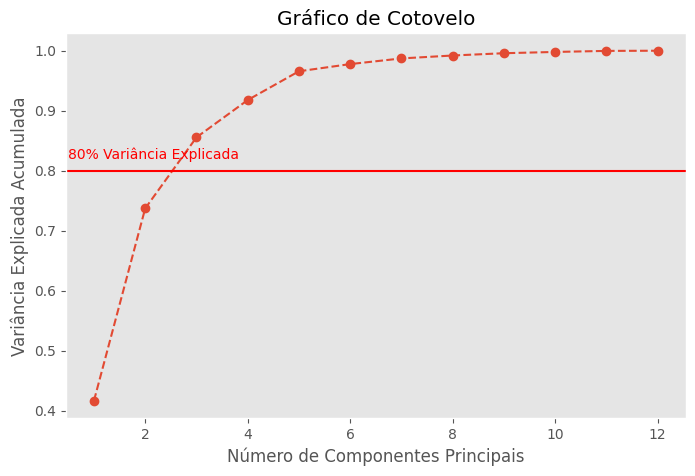

Número de componentes para atingir 80% de variância explicada: 3


In [6]:
# Normalizar os dados de treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar PCA apenas no conjunto de treino
pca = PCA()
pca.fit(X_train_scaled)

# Variância explicada acumulada
explained_variance = pca.explained_variance_ratio_.cumsum()

# Definir o limiar de variância explicada desejada
threshold = 0.80

# Calcular o número de componentes necessários para atingir o limiar
num_components = next(i for i, total_variance in enumerate(explained_variance) if total_variance >= threshold) + 1

# Plotar o gráfico de cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')
plt.text(0.5, threshold + 0.02, f'{int(threshold*100)}% Variância Explicada', color='red', fontsize=10)
plt.title('Gráfico de Cotovelo')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.grid()
plt.show()

# Exibir o número de componentes escolhidos
print(f"Número de componentes para atingir {int(threshold*100)}% de variância explicada: {num_components}")

### Aplicação
Aplicamos o PCA no conjunto de treinamento, e depois transformamos o conjunto de testes usando o mesmo PCA.\
Também tomei o cuidado de preservar os índices mesmo após o processo do PCA (faz alguma diferença?)

In [7]:
# Converter o array normalizado de volta para DataFrame com índices originais
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Aplicar PCA apenas no conjunto de treino
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_scaled_df)

# Converter o array PCA de volta para DataFrame com índices originais
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(num_components)], index=X_train.index)

# Transformar o conjunto de teste usando o mesmo PCA ajustado
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_pca = pca.transform(X_test_scaled_df)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(num_components)], index=X_test.index)

## Modelos e Treinamento

In [8]:
# Mapeamento dos rótulos de classe para valores numéricos
label_mapping = {'Alta Precipitação': 1, 'Baixa Precipitação': 0}

# Aplicar o mapeamento aos dados de treinamento e teste
y_train_numeric = y_train.map(label_mapping)
y_test_numeric = y_test.map(label_mapping)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Lista de modelos com hiperparâmetros para grid search
lista_modelos = [
    {
        "nome_do_modelo": "Random Forest",
        "estimador": RandomForestClassifier(random_state=42),
        "parametros": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    {
        "nome_do_modelo": "Logistic Regression",
        "estimador": LogisticRegression(random_state=42, max_iter=1000),  # max_iter aumentado para garantir a convergência
        "parametros": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear", "saga"],  # Solvers que suportam regularização L1 e L2
            "penalty": ["l2", "l1"]  # Tipo de regularização
        }
    }
]




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

....nando modelo Random Forest .
-- coletando e armazenando resultados --

 - Acurácia   : 0.7200 +/- 0.02449
 - Precisão   : 0.7316 +/- 0.04371
 - Revocação  : 0.6533 +/- 0.13885
 - F1 - Score : 0.6783 +/- 0.06987
 - ROC - AUC  : 0.7917 +/- 0.06711
 - PR - AUC   : 0.8047 +/- 0.07159
 - Tempo médio de treinamento: 7.10 segundos


...inando modelo Logistic Regression ..
-- coletando e armazenando resultados --

 - Acurácia   : 0.6800 +/- 0.05099
 - Precisão   : 0.6767 +/- 0.08731
 - Revocação  : 0.6778 +/- 0.12649
 - F1 - Score : 0.6615 +/- 0.05489
 - ROC - AUC  : 0.7607 +/- 0.05421
 - PR - AUC   : 0.7730 +/- 0.06840
 - Tempo médio de treinamento: 0.17 segundos


Terminado em 27/01/2025 12:37:03


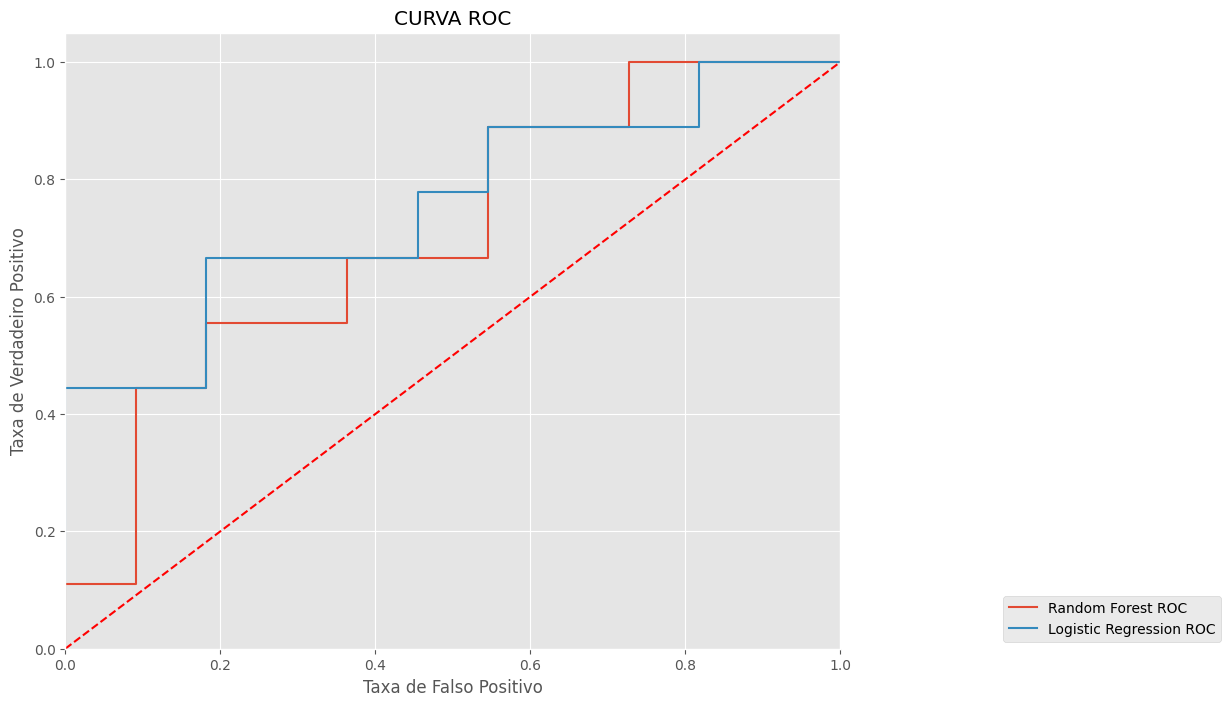

In [10]:
from classification_train_util import nested_cross_validation_grid_search

# Função de validação cruzada aninhada adaptada
resultados_gerais = nested_cross_validation_grid_search(
    lista_modelos=lista_modelos,
    X=X_train_pca_df,
    y=y_train_numeric,
    k_folds_outer=5,
    k_folds_inner=5,
    rand_state=42
)

In [ ]:
# Visualizar os resultados
print("\nResultados Gerais:")
for modelo, resultados in resultados_gerais.items():
    print(f"Modelo: {modelo}")
    for metrica, valor in resultados.items():
        if isinstance(valor, list):
            print(f"  {metrica}: {valor[:5]}...")  # Exibe apenas os primeiros valores se for uma lista
        else:
            print(f"  {metrica}: {valor}")
    print("\n")

In [13]:
# Escolher a métrica para determinar o melhor modelo
melhor_metrica = "F1_score_mean"

# Encontrar o modelo com o melhor F1-score médio
melhor_modelo_nome = max(resultados_gerais.items(), key=lambda x: x[1][melhor_metrica])[0]
melhor_modelo_info = resultados_gerais[melhor_modelo_nome]
melhor_modelo = melhor_modelo_info["melhores_modelos"][0]  # Pegue o primeiro modelo treinado

print(f"O melhor modelo é: {melhor_modelo_nome}")
print(f"Parâmetros do melhor modelo: {melhor_modelo_info['melhores_parametros'][0]}")

O melhor modelo é: Random Forest
Parâmetros do melhor modelo: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


In [15]:
from sklearn import metrics

# Prever no conjunto de teste
y_test_pred = melhor_modelo.predict(X_test_pca_df)

# Calcular métricas no conjunto de teste
test_accuracy = metrics.accuracy_score(y_test_numeric, y_test_pred)
test_precision = metrics.precision_score(y_test_numeric, y_test_pred)
test_recall = metrics.recall_score(y_test_numeric, y_test_pred)
test_f1 = metrics.f1_score(y_test_numeric, y_test_pred)

print("\nAvaliação no Conjunto de Teste:")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"Precisão: {test_precision:.4f}")
print(f"Revocação: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Avaliação no Conjunto de Teste:
Acurácia: 0.7692
Precisão: 0.9167
Revocação: 0.6875
F1-Score: 0.7857
